In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
from single_photons.utils.constants import *
from single_photons.environment import Particle

In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 10*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [3]:
gamma = 0.001
coupling = 0.01
eta_detec=0.9
env = Particle(omega, gamma, coupling, eta_detection=eta_detec)

In [4]:
variance_process = 2*env.__gamma__ + np.power(env.backaction, 2)
std_detection = 4

In [5]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [6]:
Ad = np.eye(2)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [7]:
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[100],[0.]])
K = np.array([[1, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q, R)
measured_states = np.zeros((N, 2))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    new_states[i,:] = states[:,0]
    measured_states[i, :] = states[:, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[0]]))
    kalman.compute_aposteriori(measured_states[i,0])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    states = env.step(states, control=0, delta_t=delta_t)

  0%|          | 0/4000 [00:00<?, ?it/s]


AttributeError: 'KalmanFilter' object has no attribute 'propagate_dynamics'

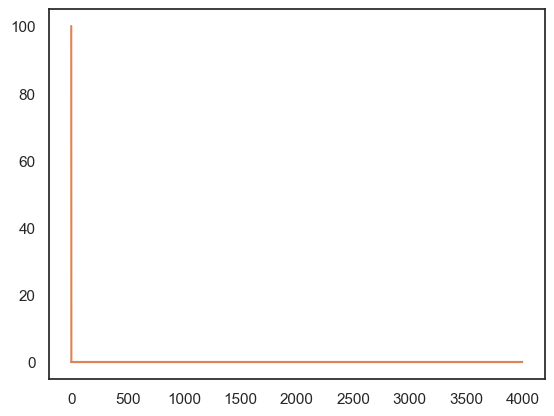

In [ ]:
#plt.plot(new_states[:,0])
#plt.plot(measured_states[:,1])
#plt.xlim([0,10000])
plt.plot(estimated_states[:,0])
plt.plot(new_states[:,0])
#plt.ylim([-.2,0])

In [15]:
z = estimated_states[:,0]*env.zp_x
p = estimated_states[:,1]*env.zp_p

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


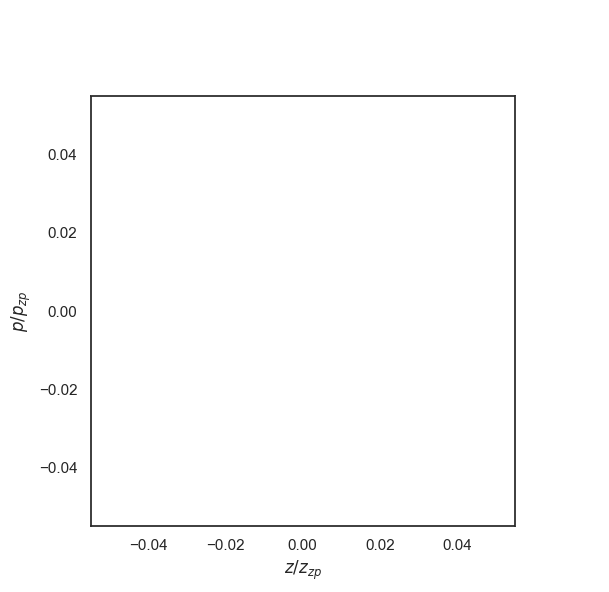

In [16]:
sns.set_theme(style="white")
df = pd.DataFrame()
df['z'] = estimated_states[100:,0]
df['p'] = estimated_states[100:,1]
g = sns.JointGrid(data=df, x="z", y="p", space=0)
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

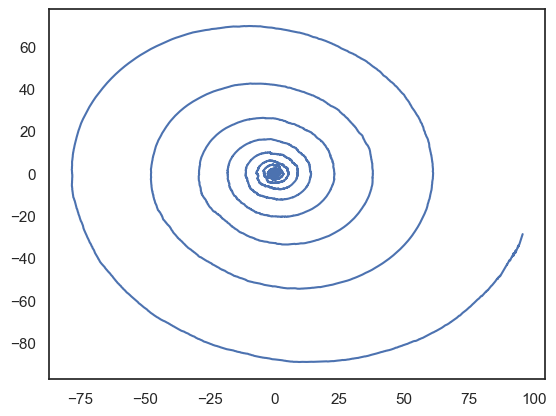

In [28]:
plt.plot(df['z'], df['p'])

In [29]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
cov_mat

matrix([[0.10503272, 0.11009689],
        [0.11009689, 0.33729983]])

In [32]:
estimated_states[-30:].var(axis=0)

array([0.00198138, 0.00214222])

In [34]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*hbar*env.__omega__)

0.22116627475764986

In [37]:
z_std*p_std > hbar/2

True